In [1]:
import numpy as np
import renom as rm
from renom.utility.distributor.distributor import NdarrayDistributor, GPUDistributor
from renom.cuda import *
import h5py
import plot3D
import voxelgrid
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from matplotlib import pyplot
import os.path

In [2]:
# Filenames for 3D-mnist data

'''
This notebook requires the 3D mnist data to be placed in the same folder
as the notebook (.ipynb) file.

The 3D-Mnist can be downloaded from Kaggle at:
https://www.kaggle.com/daavoo/3d-mnist


'''

train_filename = 'train_point_clouds.h5'
test_filename  = 'test_point_clouds.h5'

In [9]:
# Manage data naming

filename = "custom_vox.hdf5"
train_name = "train_data"
test_name = "test_data"
data_name = "data"
labels_name = "labels"

# Check if we've already created the data before

create_data = not os.path.isfile(filename)
if create_data:
    print("Voxels were not found.")
else:
    print("Voxels were found")

Voxels were found


In [7]:
# Create and write data to file if not found already

if create_data:
    print("Creating Data")
    with h5py.File(train_filename,'r') as train_file:
        voxels = []
        labels = []
        for key in train_file.keys():
            # The point clouds are turned into voxels (20,20,20) voxel grids
            voxels.append(voxelgrid.VoxelGrid(train_file[key]['points'], x_y_z = [20,20,20]).vector)
            labels.append(train_file[key].attrs['label'])
            
        labels = np.array(labels).reshape(-1,1)
        # We binarize the labels to make it easier for dense layers to guess the label as it
        # is generally easier to learn an activation function rather than a linear one
        labels = LabelBinarizer().fit_transform(labels).astype(precision)
        
        # Renom ConvNd expects a channel input, usually in 2D images known as RGB or HSV.
        # Since we only have one channel for our 3D images, we reshape it into (1,20,20,20)
        voxels = np.array(voxels).reshape(-1,1,20,20,20)
    
    with h5py.File(test_filename,'r') as test_file:
        test_voxels = []
        test_labels = []
        for key in test_file.keys():
            test_voxels.append(voxelgrid.VoxelGrid(test_file[key]['points'], x_y_z = [20,20,20]).vector)
            test_labels.append(test_file[key].attrs['label'])
            
        test_labels = np.array(test_labels).reshape(-1,1)
        test_labels = LabelBinarizer().fit_transform(test_labels).astype(precision)
        test_voxels = np.array(test_voxels).reshape(-1,1,20,20,20)
    

    with h5py.File(filename,"w") as tmp_file:
        grp = tmp_file.require_group(train_name)
        dset = grp.require_dataset(data_name, shape=voxels.shape,dtype=voxels.dtype, exact=True)
        dset[...] = voxels
        lset = grp.require_dataset(labels_name,shape=labels.shape,dtype=labels.dtype)
        lset[...] = labels
        grp = tmp_file.require_group(test_name)
        dset = grp.require_dataset(data_name, shape=test_voxels.shape,dtype=test_voxels.dtype, exact=True)
        dset[...] = test_voxels
        lset = grp.require_dataset(labels_name,shape=test_labels.shape,dtype=test_labels.dtype)
        lset[...] = test_labels
else:
    print("Skipping data creation")

Creating Data


In [5]:
# Read data from file if found

if not create_data:
    print("Reading Data")
    with h5py.File(filename,"r") as tmp_file:
        assert train_name in tmp_file and test_name in tmp_file
        grp = tmp_file[train_name]
        assert data_name in grp and labels_name in grp
        voxels = np.array(grp[data_name])
        labels = np.array(grp[labels_name])
        grp = tmp_file[test_name]
        assert data_name in grp and labels_name in grp
        test_voxels = np.array(grp[data_name])
        test_labels = np.array(grp[labels_name])
        

Reading Data


In [14]:
# Data demonstration (check that the data has loaded properly)

print(test_voxels.shape)
print(test_labels.shape)
index = 500
print(type(test_voxels[index][0]))
print(test_labels[index], "=", np.argmax(test_labels[index]))
plot3D.plot_voxelgrid(test_voxels[index][0])

(1000, 1, 20, 20, 20)
(1000, 10)
<class 'numpy.ndarray'>
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] = 2


In [7]:
# Define our 3D-Mnist model

class MNist3D(rm.Model):
    def __init__(self):
        super(MNist3D,self).__init__()
        self.l1 = rm.ConvNd(channel=32,filter=5,padding=2)
        self.a1 = rm.Relu()
        self.l2 = rm.MaxPoolNd(kernel=2,stride=2)
        self.l3 = rm.ConvNd(channel=64,filter=5,padding=2)
        self.l4 = rm.MaxPoolNd(kernel=2,stride=2)
        self.l5 = rm.Dense(1024)
        self.l6 = rm.Dense(10)
        
    def forward(self,x):
        ret = self.l1(x)
        ret = self.a1(ret)
        ret = self.l2(ret)
        ret = self.l3(ret)
        ret = self.l4(ret)
        ret = self.a1(ret)
        ret = ret.reshape(ret.shape[0],-1)
        ret = self.l5(ret)
        ret = self.a1(ret)
        ret = self.l6(ret)
        return ret

In [8]:
# Set up necessary hyperparameters

set_cuda_active(True)
batch_size = 100
epochs = 20
opt = rm.Sgd(0.001)
distributor = NdarrayDistributor(voxels,labels)
model = MNist3D()
batches = voxels.shape[0]

In [9]:
# A function to interface getting a test loss

def get_test_loss():
    z = model(test_voxels)
    loss = rm.softmax_cross_entropy(z,test_labels)
    return loss

In [10]:
%%time
# Train the model

training_loss = []
testing_loss = []
for e in range(epochs):
    loss = 0
    for batch_data, batch_labels in distributor.batch(batch_size):
        with model.train():
            z = model(batch_data)
            l = rm.softmax_cross_entropy(z,batch_labels)
            
        l.grad().update(opt)
        loss += l
    loss /= batches//batch_size+1
    training_loss.append(loss)
    test_loss = get_test_loss()
    testing_loss.append(test_loss)
    
    print("Finished epoch #{:d} with training loss of {}, testing loss of {}".format(e+1, loss, test_loss))

Finished epoch #1 with training loss of [2.6630394], testing loss of [0.92473155]
Finished epoch #2 with training loss of [0.6098353], testing loss of [0.5909783]
Finished epoch #3 with training loss of [0.4274012], testing loss of [0.48659033]
Finished epoch #4 with training loss of [0.34002188], testing loss of [0.40627193]
Finished epoch #5 with training loss of [0.28239328], testing loss of [0.37116373]
Finished epoch #6 with training loss of [0.24249189], testing loss of [0.35545552]
Finished epoch #7 with training loss of [0.2101392], testing loss of [0.32882676]
Finished epoch #8 with training loss of [0.18417865], testing loss of [0.32931426]
Finished epoch #9 with training loss of [0.16089031], testing loss of [0.3011228]
Finished epoch #10 with training loss of [0.14371794], testing loss of [0.29657635]
Finished epoch #11 with training loss of [0.12799378], testing loss of [0.28185415]
Finished epoch #12 with training loss of [0.11064398], testing loss of [0.27544436]
Finishe

<IPython.core.display.Javascript object>


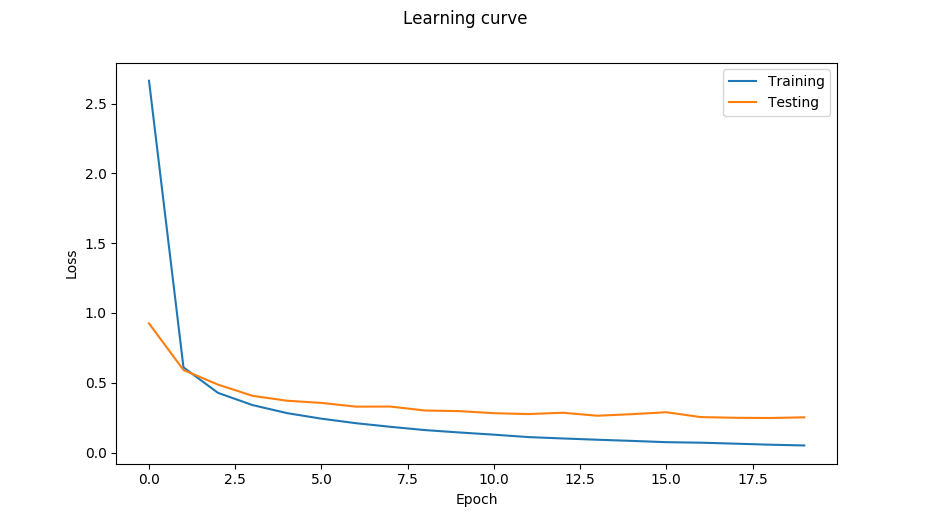

In [11]:
%matplotlib notebook

# Show the learning curve of the model

fig, ax = pyplot.subplots()
ax.plot(range(epochs),training_loss,label="Training")
ax.plot(range(epochs),testing_loss,label="Testing")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
fig.suptitle("Learning curve")
fig.show(False)

In [12]:
# Retrieve accuracy of model

predictions = model(test_voxels).as_ndarray()
predictions = np.array(np.argmax(predictions,axis=1))
label = np.array(np.argmax(test_labels,axis=1))

print(confusion_matrix(label, predictions))
print(classification_report(label, predictions))

[[ 82   0   0   0   0   0   2   0   0   1]
 [  0 124   0   0   0   0   1   0   1   0]
 [  1   0 104   1   1   0   0   5   4   0]
 [  0   0   0  98   1   6   0   1   0   1]
 [  0   1   0   0  95   0   3   1   2   8]
 [  0   0   0   0   0  83   0   0   4   0]
 [  2   0   0   0   0   0  85   0   0   0]
 [  0   0   0   3   2   0   0  90   1   3]
 [  2   0   2   3   1   2   0   0  76   3]
 [  0   0   0   2   1   0   0   3   2  86]]
             precision    recall  f1-score   support

          0       0.94      0.96      0.95        85
          1       0.99      0.98      0.99       126
          2       0.98      0.90      0.94       116
          3       0.92      0.92      0.92       107
          4       0.94      0.86      0.90       110
          5       0.91      0.95      0.93        87
          6       0.93      0.98      0.96        87
          7       0.90      0.91      0.90        99
          8       0.84      0.85      0.85        89
          9       0.84      0.91      